# Tutorial 4 (Week 5) - Supervised and Unsupervised Learning

## Learning Objectives

After completing this tutorial, you should be able to:

+ Prepare data for learning
  + Perform train-test split
  + Perform punctuation and stopword removal
  + Perform feature generation and vocabulary learning
  + Write custom transformer
+ Perform supervised learning
  + Perform classification using Naive Bayes
  + Perform regression
+ Perform unsupervised learning
  + Perform k-means clustering

In [1]:
import pandas as pd
import numpy as np

# Supervised Learning - Spam Classification Example

## Dataset

Let's try to handle a new type of data: text data. Given a collection of text messages, we want to be able to classify whether a message is a spam or not. This is a binary classification problem. 

We use the [SMS Spam Collection](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) dataset from UC Irvine. The text data file and the accompanying `readme` file have been downloaded for you in the tutorial folder. Check the `readme` file to understand the data format.

Let's first load the dataset into a DataFrame named `sms`. Our usual `read_csv` function also supports loading text data. Check the function documentation and set the correct parameters to load this dataset properly.

_(Hint: What is the separator? Does it have headers?)_

In [2]:
# TODO
sms = pd.read_csv( 'T4-SMSSpamCollection', sep="\t", header=None )
sms.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The first column contains the labels for message in the second column: "spam" if the message is a spam, or "ham" if it is not a spam.

Let's clean the dataset by renaming the columns with meaningful headers `label` and `message`. 

In [3]:
# TODO
sms = sms.rename( columns={ 0:'label', 1:'message' })
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Train-Test Split

To avoid overfitting, it is common practice when performing a supervised machine learning experiment to hold out part of the available data as a _test set_, to be used for evaluating the model performance after training. 

__It is important that the splitting of data into training and test subsets are done _before_ any preprocessing.__ That is, data preprocessing steps (which we learned in the previous tutorial) should be applied to the training set and the test set separately. This prevents _data leakage_, where information from test data is used to make choices when building the model, resulting in overly optimistic performance estimates.

In scikit-learn, a random split into training and test sets can be quickly computed with the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) helper function.

Whenever randomization is part of a Scikit-learn algorithm, a `random_state` parameter may be provided to control the random number generator used. In order to obtain reproducible (i.e., constant) results across multiple program executions, we need to remove all uses of `random_state=None`, which is the default. The recommended way in sklearn is to declare a `rng` variable at the top of the program, and pass it down to any object that accepts a `random_state` parameter.

In [4]:
rng = np.random.RandomState(0)
from sklearn.model_selection import train_test_split

sms_train, sms_test = train_test_split( sms, test_size=0.20, random_state=rng ) 

In [5]:
print( "No of samples in training set: %s" % len(sms_train) )
print( "No of samples in test set: %s" % len(sms_test) )

No of samples in training set: 4457
No of samples in test set: 1115


In the above, we use a split ratio of 80:20 (specified in the `test_size` parameter), which means 80% of the data is used for training and 20% is held out for testing. This ratio is commonly used and is usually a good starting point.

In general, determining the appropriate ratio for a machine learning problem involves considerations such as having sufficient data size, ensuring that the sets have satisfactory variance and adequate representation of the actual distribution, computational costs, etc.

## Training Data Preprocessing

As the aim of this tutorial is not preprocessing, we will do quick operations and majorly focus on handling text data and learning to train a model.

Let us first get quick descriptive statistics of the training set. The statistics summary of this text data will look rather different from that of numerical data that we have mostly seen in previous tutorials.

In [6]:
# TODO
sms_train.describe()

,label,message
count,4457,4457
unique,2,4206
top,ham,"Sorry, I'll call later"
freq,3870,26


Let's also check the descriptive statistics for individual `ham` and `spam` categories.

In [7]:
# TODO
sms_train.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      3870   3668                             Sorry, I'll call later   26
spam      587    538  I don't know u and u don't know me. Send CHAT ...    3

### Punctuation and Stopword Removal

Python's `string` library has a pre-defined constant string `punctuation` that contains all punctuation characters.

In [8]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

There are more than one ways to remove punctuations from a string. In this tutorial, we will use an approach based on [regular expression](https://docs.python.org/3/library/re.html#module-re) (regex), which essentially matches the defined regex pattern for punctuations and replaces it with empty string.

In this case, the regex pattern is simply the occurence of any character from `string.punctuation`, plus other characters we want to discard for our purpose. For our spam message classification task, we will also discard digits, tab and newline characters.

The following code compiles this pattern into a regex object, which we can then use on our text messages. Note that special characters such as those in `string.punctuation` need to be escaped in the regex.

In [9]:
import re

regex = re.compile( '[' + re.escape(string.punctuation) + '0-9\\r\\t\\n'+']' )
regex.pattern

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~0-9\\r\\t\\n]'

__Stopword__ refers to commonly used words, such as "a", "the", "is", etc. These words are not providing very useful information and hence are generally removed during preprocessing.

The [Natural Language Toolkit (NLTK)](https://www.nltk.org/) library has a list of stopwords that we can use to filter out stopwords from the text messages.

In [10]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop = stopwords.words('english')
#stop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HYQ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now let us write a function `textProcess` that takes in a text input, removes punctuation and stopwords, and returns the count of remaining words. Complete the code segment below.

In [11]:
def textProcess( text, verbose=False ): 
    
    try:
        if verbose==True:
            print( text )
            
        # TODO: Convert the text to lowercase first
        # text = ?
        text = text.lower()
        
        if verbose==True:
            print( text )

        # TODO: Remove punctuation using the regex object
        # text = ?
        text = regex.sub( '', text )
        
        if verbose==True:
            print( text )
        
        # TODO: Remove stopwords: split text into individual words, and save non-stopwords into an array
        # words = ?
        words = [w for w in text.split(' ')
                if w not in stop]

        if verbose==True:
            print( words )
        
        # TODO: Return the count of remaining words
        return len( words )

    except:
        return 0

Let's test our function on a sample message:

In [12]:
textProcess( sms_train['message'].iloc[199], verbose=True )

New car and house for my parents.:)i have only new job in hand:)
new car and house for my parents.:)i have only new job in hand:)
new car and house for my parentsi have only new job in hand
['new', 'car', 'house', 'parentsi', 'new', 'job', 'hand']


7

### Feature Generation

Let us now generate a few new features and store them as new columns:
- `length`: character count of the original text message
- `word_count`: word count of the original text message
- `processed_word_count`: word count of the processed text message

We can use [`Series.apply`](https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) to invoke the desired functions on each data value in the Series.

In [13]:
# TODO: Generate length feature
sms_train['length'] = sms_train['message'].apply(len)

In [14]:
# TODO: Generate word_count feature
sms_train['word_count'] = sms_train['message'].apply( lambda x: len( [w for w in x.split(' ')] ))

In [15]:
# TODO: Generate preprocessed_word_count feature
sms_train['processed_word_count'] = sms_train['message'].apply( lambda x: textProcess(x) )

In [16]:
sms_train.head()

,label,message,length,word_count,processed_word_count
1114,ham,"No I'm good for the movie, is it ok if I leave...",61,15,6
3589,ham,If you were/are free i can give. Otherwise nal...,72,13,9
3095,ham,Have you emigrated or something? Ok maybe 5.30...,67,12,7
1012,ham,"I just got home babe, are you still awake ?",43,10,6
3320,ham,Kay... Since we are out already,32,7,4


Let's put these three features that we have generated into a NumPy array, in preparation to build our training dataset (the `x` in our machine learning recipe).

In [17]:
x_train = sms_train[['length', 'word_count', 'processed_word_count']].to_numpy()
x_train

array([[ 61,  15,   6],
       [ 72,  13,   9],
       [ 67,  12,   7],
       ...,
       [122,  19,  15],
       [ 56,  15,   9],
       [ 53,  10,   7]], dtype=int64)

We also encode the `spam`/`ham` labels as numeric values `1`/`0` and save them in an array (the `y` in our machine learning recipe).

In [18]:
y_train = [1 if l=="spam" else 0 for l in sms_train['label']]
#y_train

### Generating Vocabulary Feature

The [sklearn.feature_extraction](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction) module includes submodules dedicated to feature extraction from images and text. 

A useful and simple utility in the `sklearn.feature_extraction.text` submodule is [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer). It implements both tokenization and occurrence counting in a single class. It can also be configured to perform preprocessing such as stopwords removal and character normalization. In this tutorial, we will just use it to generate a word count vector.

The `fit_transform` method of `CountVectorizer` learns the vocabulary dictionary and return the document-term matrix. Each term found during the fit is assigned a unique integer index corresponding to a column in the resulting matrix.

![CountVectorizer](https://www.educative.io/api/edpresso/shot/5197621598617600/image/6596233398321152)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform( sms_train.message )

print( "No of samples in the training set: %s" % len(sms_train) )
X_train_counts.shape

No of samples in the training set: 4457


(4457, 7793)

We can view the features in the `CountVectorizer` transformation (i.e., the vocabulary learned) using `get_feature_names_out()`. The length of this list should correspond to the number of columns in `X_train_counts` (refer to the illustration above).

In [22]:
# TODO: vocab = ?
vocab = count_vect.get_feature_names_out()

In [23]:
print( len(vocab) )
vocab[1000:1100] # view a subset

7793


array(['anyones', 'anyplaces', 'anythin', 'anything', 'anythingtomorrow',
       'anytime', 'anyway', 'anyways', 'anywhere', 'aom', 'apart',
       'apartment', 'apes', 'aphex', 'apnt', 'apo', 'apologise',
       'apologize', 'app', 'apparently', 'appeal', 'appear', 'appendix',
       'applebees', 'apples', 'application', 'apply', 'applyed',
       'applying', 'appointment', 'appointments', 'appreciate',
       'appreciated', 'approaches', 'approaching', 'appropriate',
       'approve', 'approved', 'approx', 'apps', 'appt', 'appy', 'april',
       'aproach', 'apt', 'aptitude', 'aquarius', 'ar', 'arab', 'arabian',
       'arcade', 'ard', 'are', 'area', 'aren', 'arent', 'arestaurant',
       'aretaking', 'areyouunique', 'argentina', 'argh', 'argue',
       'arguing', 'argument', 'arguments', 'aries', 'arise', 'arises',
       'arithmetic', 'arm', 'armand', 'armenia', 'arms', 'arng', 'arngd',
       'arnt', 'around', 'aroundn', 'arr', 'arrange', 'arrested',
       'arrive', 'arrived', 'ar

Let's try to check the feature vector generated for one of the messages, say at index 900.

In [24]:
sms_train['message'].iloc[900]

"I jus hope its true that  missin me cos i'm really missin him! You haven't done anything to feel guilty about, yet."

In [25]:
cts = X_train_counts.toarray()
cts[900]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

The array has nonzero values only at indices corresponding to the words in the vocabulary, where the values indicate the number of occurences of that word in the message.

In [26]:
nonzero_idx = np.nonzero( cts[900] )
nonzero_idx

(array([ 763, 1003, 2018, 2409, 2804, 3296, 3376, 3453, 3508, 3793, 3903,
        4433, 4535, 5642, 6862, 6986, 7098, 7743, 7756], dtype=int64),)

Using the vocabulary word list (`vocab`), vocabulary count array for the message (`cts[900]`), and indices of nonzero values for the message (`nonzero_idx`), can you find out the following?
- Total word count of the message
- The list of words in the message
- The count of each word in the message

In [27]:
# TODO: Total word count
cts[900].sum()

20

In [28]:
# TODO: List of words
vocab[nonzero_idx]

array(['about', 'anything', 'cos', 'done', 'feel', 'guilty', 'haven',
       'him', 'hope', 'its', 'jus', 'me', 'missin', 'really', 'that',
       'to', 'true', 'yet', 'you'], dtype=object)

In [29]:
# TODO: Count of each word
cts[900][nonzero_idx]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
      dtype=int64)

This vocabulary that `count_vect` has learned is now stored as its attribute. Any other words that are not part of this list (i.e., not seen in the training set) will be completely ignored in future calls to its `transform` method (e.g., when run on the test set).

In [30]:
count_vect.transform(["alamak"]).toarray().sum()

0

Let us now create the training dataset by putting together this vocabulary count vector with the character/word count features that we had earlier. Do note that essentially the vocabulary count vector is also providing us information regarding the count of the words. We do not really expect to see huge improvements with this approach. But we are continuing in this tutorial so as to learn about mixing and using such differently created features.

In [31]:
trainData = np.hstack( (cts, x_train) )
trainData

array([[  0,   0,   0, ...,  61,  15,   6],
       [  0,   0,   0, ...,  72,  13,   9],
       [  0,   0,   0, ...,  67,  12,   7],
       ...,
       [  0,   0,   0, ..., 122,  19,  15],
       [  0,   0,   0, ...,  56,  15,   9],
       [  0,   0,   0, ...,  53,  10,   7]], dtype=int64)

## Test Data Preprocessing

All data transformations that are applied when training a model must also be used on subsequent datasets, whether it is the test set or data in a production system. Otherwise, the feature space will change, and the model will not be able to perform effectively.

Let us first try to apply one by one, the same preprocessing steps that we have done on the training dataset, to the test set. We start by generating the array of character and word count features.

In [32]:
# TODO: Generate length, word_count, and processed_word_count features for the test set
sms_test['length'] = sms_test['message'].apply(len)
sms_test['word_count'] = sms_test['message'].apply( lambda x: len( [w for w in x.split(' ')] ))
sms_test['processed_word_count'] = sms_test['message'].apply( lambda x: textProcess(x) )
sms_test.head()

,label,message,length,word_count,processed_word_count
4456,ham,"Storming msg: Wen u lift d phne, u say ""HELLO""...",324,79,52
690,spam,<Forwarded from 448712404000>Please CALL 08712...,111,15,8
944,ham,And also I've sorta blown him off a couple tim...,116,24,13
3768,ham,"Sir Goodmorning, Once free call me.",35,6,4
1189,ham,All will come alive.better correct any good lo...,73,11,6


In [33]:
# TODO: x_test = ?
x_test = sms_test[['length', 'word_count', 'processed_word_count']].to_numpy()
x_test

array([[324,  79,  52],
       [111,  15,   8],
       [116,  24,  13],
       ...,
       [106,  27,  15],
       [169,  27,  18],
       [ 27,   5,   1]], dtype=int64)

We encode the `spam`/`ham` labels as well.

In [34]:
# TODO: y_test = ?
y_test = [1 if l=="spam" else 0 for l in sms_test['label']]
#y_test

Now, we need to be careful when applying transformations.

Although both train and test data subsets should receive the same preprocessing transformations, __it is important that these transformations are only learnt from the training data__. For example, if we have a normalization step that divides by the average value, the average should be the average of the training subset, not the average of all the data. If the test subset is included in the average calculation, information from the test subset is influencing the model, that is, the _data leakage_ problem described earlier.

In other words, the general rule is to __never call `fit` on the test data__. 

Thus, to generate the vocabulary count vector for the test data, we use the same `CountVectorizer` transformer initialized earlier, but apply `transform` only instead of `fit_transform`.

In [35]:
# TODO: X_test_counts = ?
X_test_counts = count_vect.transform( sms_test.message )
X_test_counts.shape

(1115, 7793)

Finally, we create the test data from the character/word counts and the vocabulary counts.

In [36]:
# TODO: testData = ?
testData = np.hstack( (X_test_counts.toarray(), x_test) )

We are now ready to perform some classification.

## Classification using Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. 

If `y` is the prediction, and the `x`-es are the features, then Bayes' theorem gives the conditional probability of `y` given `x`. Using the conditional assumption among features, the equations are simplified to provide us an estimate of `y`. The different Naive Bayes algorithms typically differ in the assumption of the distribution of feature given the `y`.

In this tutorial, we do not aim to understand a specific classifier, or its working. The aim is to understand how we can experiment with the features and perform predictions using `sklearn`. Once the implementation is understood, the classifiers in `sklearn` can be changed according to the problem at hand. 

In this tutorial, we will try two different Naive Bayes algorithms available in `sklearn`: _Multinomial Naive Bayes_ and _Complement Naive Bayes_. The [User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) is a useful resource to find simple explanations regarding what can be used.

In [37]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB

### Multinomial Naive Bayes

Let's try this classifier on the training data set with fewer features, `x_train`. We start by instantiating the classifier and fitting it to the training data and labels.

In [38]:
clf = MultinomialNB()
clf.fit( x_train, y_train )

MultinomialNB()

We write a function to let us examine the confusion matrix and performance scores of the prediction.

In [39]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score

def evaluate( y_pred, y_test ):
    
    print( "-----------" )

    c = confusion_matrix( y_test, y_pred ) #[[TN, FP],[FN,TP]]
    tn, fp, fn, tp = c.ravel() # returns a flattened array

    print( c )
    print( "-----------" )
    
    print( "Accuracy:", str( accuracy_score( y_test, y_pred )))
    
    sens, spec = tp/(tp+fn), tn/(tn+fp) 
    print( "Specificity: {0}, Sensitivity: {1}".format(spec, sens) )
    print( "Precision:", str( precision_score( y_test, y_pred )))

Now, we perform the prediction on the corresponding `x_test` and evaluate the results.

In [40]:
y_pred = clf.predict( x_test )

evaluate( y_pred, y_test )

-----------
[[955   0]
 [160   0]]
-----------
Accuracy: 0.8565022421524664
Specificity: 1.0, Sensitivity: 0.0
Precision: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Complement Naive Bayes

Complement Naive Bayes is an adaptation of the standard Multinomial Naive Bayes algorithm that is particularly suited for imbalanced data sets. Imbalanced datasets are datasets where the number of examples of some class is higher than the number of examples belonging to other classes.

Let's try this classifier on the training data set with more features, `trainData`. Similarly, start by instantiating the classifier and fitting it to the training data and labels.

In [41]:
# TODO
clf = ComplementNB()

clf.fit( trainData, y_train )

ComplementNB()

Now perform the prediction on the corresponding test data, and evaluate it.

In [42]:
# TODO
y_pred = clf.predict( testData )

evaluate( y_pred, y_test )

-----------
[[945  10]
 [ 11 149]]
-----------
Accuracy: 0.9811659192825112
Specificity: 0.9895287958115183, Sensitivity: 0.93125
Precision: 0.9371069182389937


## Chaining Estimators

In the above, we have applied preprocessing steps one by one. Instead of doing so, we can combine the steps into a transformer object that we can then apply conveniently to multiple datasets. We have seen in the previous tutorial that some of the ways for us to combine transformations are `Pipeline` or `ColumnTransformers`.

In this tutorial, we used `CountVectorizer` which is already a transformer class, but we also did custom preprocessing to generate character/word counts. We can write our custom transformer to do such custom preprocessing.

### Writing A Custom Transformer

`sklearn.preprocessing` module provides [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer), which allows us to implement a transformer from an arbitrary function. However, if we do not have a specific function to implement as transformer, but want flexibility to implement our operations, we can write our transformer using two baseclasses from `sklearn`:

1. [`BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html): provides `get_params` and `set_params` functions. 

2. [`TransformerMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html): provides `fit_transform` function when we define our own `fit` and `transform` functions.

In general, it is good to note that all estimators should specify all the parameters that can be set at the class level in their `__init__` as explicit keyword arguments. However, for our transformation, we are not storing any transformer parameters, and hence can also skip the `__init__` function.

This [guide](https://scikit-learn.org/stable/developers/develop.html) is useful in understanding the specifications of each component in our custom transformer.

Let's create a transformer that generates the `length`, `word_count` and `processed_word_count` features in the data. We name this class `FeatureCreator` and implement its `fit` and `transform` methods. Each of these methods takes in the estimator object `self`, sample data `X`, and labels `y` (for supervised learning).

Complete the code below.

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureCreator( BaseEstimator, TransformerMixin ):
    
    def fit( self, X, y=None ):
        
        # Nothing to be done for fit in this transformation
        # Return fitted estimator
        return self
    
    def transform( self, X, y=None ):
        
        # Initialize the DataFrame
        self.df = pd.DataFrame()
        self.df['length'] = X.apply( len )
        
        # TODO: Generate word_count and processed_word_count as you did previously
        self.df['word_count'] = X.apply( lambda x: len( [w for w in x.split(' ')] ))
        self.df['processed_word_count'] = X.apply( lambda x: textProcess(x) )
               
        # Return transformed data
        return self.df

Let's test it on our original `sms_train` message data.

In [44]:
featCreator = FeatureCreator()
x_train = featCreator.fit_transform( sms_train['message'] )

print( x_train.shape )
x_train

(4457, 3)


,length,word_count,processed_word_count
1114,61,15,6
3589,72,13,9
3095,67,12,7
1012,43,10,6
3320,32,7,4
...,...,...,...
4931,124,24,13
3264,23,6,5
1653,122,19,15
2607,56,15,9


We can also write a simple transformer to convert a sparse matrix to array, which will come in useful later.

In [45]:
class DenseTransformer( TransformerMixin ):

    def fit( self, X, y=None, **fit_params ):
        return self

    def transform( self, X, y=None, **fit_params ):
        return X.toarray()

### FeatureUnion 

[`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion) is another class from `sklearn.pipeline`. It takes a list of transformer objects and creates a new transformer that combines their output. During fitting, each of these is fit to the data _independently_. The transformers are applied in parallel, and the feature matrices they output are concatenated side-by-side into a larger matrix.

Do note here that the each transformer object is fit to _the entire data_. If we want to specify different transformers for different columns, we can go back to [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) covered in the previous tutorial.

We will use `FeatureUnion` as well as `Pipeline` to combine our transformations.

In [107]:
from sklearn.pipeline import Pipeline, FeatureUnion

We create a `Pipeline` to chain together `CountVectorizer` (to generate vocabulary counts) and `DenseTransformer` (to convert the `CountVectorizer` sparse matrix output to array) as these should occur sequentially. Recall how to do this from previous tutorial.

In [108]:
# TODO: tf_pipeline = ?
tf_pipeline = Pipeline( [("countvec", count_vect), ("to_dense",DenseTransformer())] )

We can combine this pipeline with our earlier `FeatureCreator` using `FeatureUnion`, since they can be performed in parallel.

In [109]:
feats = FeatureUnion( [("lengths", featCreator), ("tf", tf_pipeline)] )

Let's try it out on our original `sms_train` message data.

In [110]:
feats.fit( sms_train['message'] )
x_train = feats.fit_transform( sms_train.message )

print( x_train.shape )
x_train

(4457, 7796)


array([[ 61,  15,   6, ...,   0,   0,   0],
       [ 72,  13,   9, ...,   0,   0,   0],
       [ 67,  12,   7, ...,   0,   0,   0],
       ...,
       [122,  19,  15, ...,   0,   0,   0],
       [ 56,  15,   9, ...,   0,   0,   0],
       [ 53,  10,   7, ...,   0,   0,   0]], dtype=int64)

Now that it works, we can conveniently apply it to our `sms_test` message data too. __Remember that we should only perform `transform` without fitting on the test data.__

In [111]:
# TODO
x_test = feats.transform( sms_test['message'] )
print( x_test.shape )
x_test

(1115, 7796)


array([[324,  79,  52, ...,   0,   0,   0],
       [111,  15,   8, ...,   0,   0,   0],
       [116,  24,  13, ...,   0,   0,   0],
       ...,
       [106,  27,  15, ...,   0,   0,   0],
       [169,  27,  18, ...,   0,   0,   0],
       [ 27,   5,   1, ...,   0,   0,   0]], dtype=int64)

### Chaining Preprocessing and Prediction

We can also chain our complete preprocessing transformer with the classifier (e.g., the Complement Naive Bayes), which we can then apply to each new dataset to preprocess them and produce the prediction in one go. 

Which one should you use for this, `Pipeline` or `FeatureUnion`?

In [112]:
# TODO: text_clf = ?
text_clf = Pipeline( [('feats', feats), ('clf', clf)] )

Now we fit the text classifier with `sms_train` message data and the training labels.

In [113]:
# TODO
text_clf.fit( sms_train['message'], y_train )

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('lengths', FeatureCreator()),
                                                ('tf',
                                                 Pipeline(steps=[('countvec',
                                                                  CountVectorizer()),
                                                                 ('to_dense',
                                                                  <__main__.DenseTransformer object at 0x000001D05211ACA0>)]))])),
                ('clf', ComplementNB())])

Use it to run prediction on the `sms_test` message data, and evaluate the result.

In [114]:
# TODO
y_pred = text_clf.predict( sms_test['message'] )
evaluate( y_pred, y_test )

-----------
[[945  10]
 [ 11 149]]
-----------
Accuracy: 0.9811659192825112
Specificity: 0.9895287958115183, Sensitivity: 0.93125
Precision: 0.9371069182389937


# Unsupervised Learning - Iris Classification Example

## Dataset

We make use of the iris dataset, which is available in scikit-learn. This dataset consists of 3 different types of irises (Setosa, Versicolour, and Virginica) with petal and sepal length data, stored in a 150 x 4 `numpy.ndarray`.

We use the [dataset loading utilities](https://scikit-learn.org/stable/datasets.html) in `sklearn` to load the data, feature names and targets for the dataset.

In [115]:
from sklearn.datasets import load_iris

iris = load_iris()

iris_df = pd.DataFrame( data=iris.data, columns=iris.feature_names )
target_df = pd.DataFrame( data=iris.target, columns=['species'] )
iris_df = pd.concat( [iris_df, target_df], axis= 1 )
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


As usual when we first examine a dataset, it is useful to check the descriptive statistics summary.

In [116]:
# TODO
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


We can also use visualization to explore this dataset. Here, we want to differentiate the species. 

Seaborn `pairplot` gives us a quick way to plot pairwise relationships in a dataset. The plot at position `(x,y)` where `x != y` gives the scatter plot of `y` against `x`, while the diagonal plots (`x == y`) show the marginal distribution of the data in each column.

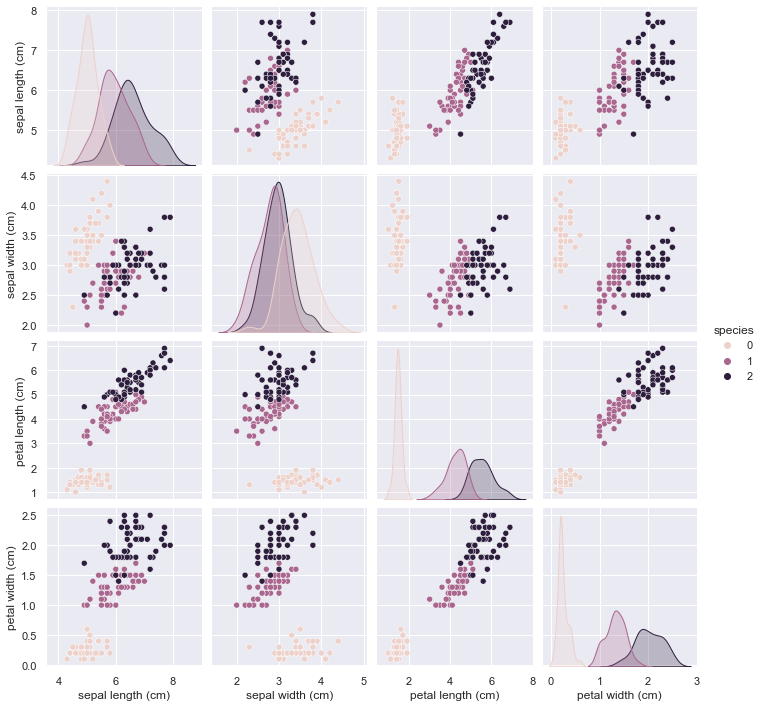

In [117]:
import seaborn as sns
sns.set_theme()

sns.pairplot( iris_df, hue='species' )

## KMeans Clustering

We try to identify how petal length and petal width vary with species. We construct the sample `X` (petal length and petal width) and labels `y` (species). For unsupervised learning, the labels are not used in training, but only in evaluating.

In [118]:
X = iris_df[['petal width (cm)', 'petal length (cm)']].values
X.shape

(150, 2)

In [119]:
y = iris_df['species'].values
len( y )

150

We use [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) as our unsupervised learning method. 

First, instantiate the `KMeans` object.

- As we know that there are 3 species to identify, we can specify `n_clusters=3`.

- As the method involves random number generation for centroid initialization, as before, we should set `random_state` to a deterministic value to allow us to get reproducible results. We can reuse the `rng` variable we declared earlier.

In [127]:
from sklearn.cluster import KMeans

# TODO: km = ?
km = KMeans( n_clusters=3, random_state=rng )

For unsupervised learning, we perform fitting only with the samples, without the labels.

In [128]:
# TODO
km.fit( X )

KMeans(n_clusters=3, random_state=RandomState(MT19937) at 0x1D051E9BA40)

We now access the clustering results via `labels_`, and add it as a column to our data for visualization purpose.

In [129]:
iris_labels = km.labels_
iris_df['species_predict'] = iris_labels

We can now plot the predicted labels in comparison with the true labels from the training set.

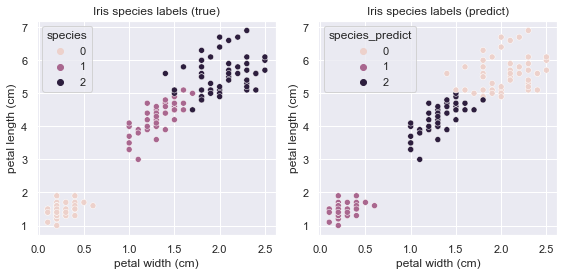

In [130]:
import matplotlib.pyplot as plt

f, axs = plt.subplots( 1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]) )
sns.scatterplot( data=iris_df, x="petal width (cm)", y="petal length (cm)", hue="species", ax=axs[0]).set(title='Iris species labels (true)' )
sns.scatterplot( data=iris_df, x="petal width (cm)", y="petal length (cm)", hue="species_predict", ax=axs[1]).set(title='Iris species labels (predict)' )
f.tight_layout()

### The Elbow Method

What if we do not know that this dataset comprises 3 different types of irises? We can find the optimal number of types of irises using the elbow method.

Our metric for how well the data is clustered for the KMeans model is *inertia*. Inertia is the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

A good model is one with low inertia and a low number of clusters (`k`). However, this is a tradeoff because as `K` increases, inertia decreases. The elbow refers to where the decrease in inertia begins to slow.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


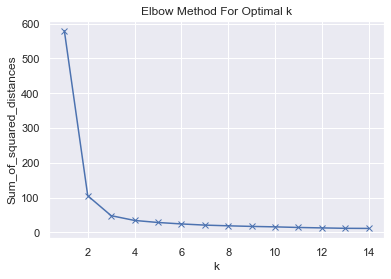

In [132]:
Sum_of_squared_distances = []
K = range( 1, 15 )

for k in K:
    km = KMeans( n_clusters=k )
    km = km.fit( X )
    Sum_of_squared_distances.append( km.inertia_ )

plt.plot( K, Sum_of_squared_distances, 'bx-' )
plt.xlabel( 'k' )
plt.ylabel( 'Sum_of_squared_distances' )
plt.title( 'Elbow Method For Optimal k' )
plt.show()

## Supervised Learning - Regression Example

We will reuse the iris dataset to do one more supervised learning method, using regression. Instead of identifying the species as in the unsupervised learning example, we now want to predict how sepal length varies with sepal width, petal length, and petal width.

The steps involved are:
+ We split the dataset into training and test datasets.
+ We fit the linear regression model on the training dataset.
+ We use the linear regression model to predict on the test dataset.
+ We calculate the mean squared error to understand goodness of fit.

First, construct the sample `X` and labels `y` in this case.

In [122]:
# TODO
X = iris_df[['petal width (cm)', 'petal length (cm)', 'sepal width (cm)']].values
y = iris_df['sepal length (cm)'].values

It is good practice to scale the dataset using `StandardScaler()`, but since data preprocessing is not the focus of this tutorial, and the magnitude of all features is the same, we skip this step.

Next, split the dataset using `train_test_split`, to use 33% of the data for testing. We can do the split for both samples and labels in one call. Revisit the [reference](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) for an example.

In [123]:
# TODO: X_train, X_test, y_train, y_test = ?
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=rng )

We perform a linear regression to fit the train dataset. We then find the $R^2$ and the coefficients of the regression equation. The attributes and methods for the `LinearRegression` class can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [124]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit( X_train, y_train )
lr.score( X_train, y_train ), lr.coef_

(0.8724066734643056, array([-0.47565612,  0.68785745,  0.64166861]))

We use the fitted linear regression model to perform predictions in the test dataset. We can also calculate metrics using the predictions. 

In [125]:
pred = lr.predict( X_test )

In [126]:
from sklearn.metrics import mean_squared_error

print( 'Mean Squared Error:', mean_squared_error( y_test, pred ))
print( 'Mean Root Squared Error:', np.sqrt( mean_squared_error( y_test, pred )))

Mean Squared Error: 0.09594119443048392
Mean Root Squared Error: 0.3097437560798989
